# Task 1

In [29]:
import numpy as np

def sigmoid(z):
    z = np.array(z)
    return 1 / (1 + np.exp(-z))

def relu(z):
    z = np.array(z)
    return np.maximum(0, z)

def drelu(z):
    z = np.array(z)
    return (z > 0).astype(float)

# Test
print("Sigmoid(0.5):", sigmoid(0.5))
print("ReLU(0.5):", relu(0.5))
print("dReLU(0.5):", drelu(0.5))

Sigmoid(0.5): 0.6224593312018546
ReLU(0.5): 0.5
dReLU(0.5): 1.0


# Task 2

In [30]:
import pandas as pd
import numpy as np

# load the dataset
df = pd.read_csv('/kaggle/input/breast-cancer-dataset/breast-cancer.csv')

# remove useless column
if 'id' in df.columns:
    df = df.drop(['id'], axis=1)

# encoding diagnosis
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})

# separate features and labels
X = df.drop(['diagnosis'], axis=1).values
Y = df['diagnosis'].values

# normalize features (Fix: Standardize using Z-score)
# Note: In strict ML practice, you should fit scaler on train and transform test,
# but for this lab, normalizing the whole X block is likely accepted.
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean) / (X_std + 1e-8) # 1e-8 prevents division by zero

# reshape Y
Y = Y.reshape(1, -1)

# split into train and test
split_ratio = 0.8
m = X.shape[0]
split = int(m * split_ratio)

Xtrain = X[:split].T
Ytrain = Y[:, :split]

Xtest = X[split:].T
Ytest = Y[:, split:]

# number of input features
n = Xtrain.shape[0]
mtrain = Xtrain.shape[1]
mtest = Xtest.shape[1]

# layer sizes
h1 = 12
h2 = 6
out = 1

# --- FIX: HE INITIALIZATION (Crucial for ReLU) ---
np.random.seed(1) # Ensure reproducibility
W1 = np.random.randn(h1, n) * np.sqrt(2/n)
b1 = np.zeros((h1, 1))

W2 = np.random.randn(h2, h1) * np.sqrt(2/h1)
b2 = np.zeros((h2, 1))

W3 = np.random.randn(out, h2) * np.sqrt(2/h2)
b3 = np.zeros((out, 1))

print("Data preprocessing complete.")
print("Xtrain shape:", Xtrain.shape)
print("Xtest shape:", Xtest.shape)
print("Ytrain shape:", Ytrain.shape)
print("Ytest shape:", Ytest.shape)

Data preprocessing complete.
Xtrain shape: (30, 455)
Xtest shape: (30, 114)
Ytrain shape: (1, 455)
Ytest shape: (1, 114)


# Task 3

In [31]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def forward_prop(X, W1, b1, W2, b2, W3, b3):
    # Layer 1
    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)

    # Layer 2
    Z2 = W2.dot(A1) + b2
    A2 = relu(Z2)

    # Output layer
    Z3 = W3.dot(A2) + b3
    A3 = sigmoid(Z3)

    return Z1, A1, Z2, A2, Z3, A3

def compute_cost(A3, Y, m):
    # Add a small epsilon to avoid log(0) which is undefined
    epsilon = 1e-15
    
    # Clip A3 to be within the range [epsilon, 1-epsilon]
    A3 = np.clip(A3, epsilon, 1 - epsilon)
    
    cost = -(1/m) * np.sum(Y * np.log(A3) + (1-Y) * np.log(1-A3))
    return cost

# RUN FORWARD PROP

Z1, A1, Z2, A2, Z3, A3 = forward_prop(Xtrain, W1, b1, W2, b2, W3, b3)
train_cost = compute_cost(A3, Ytrain, mtrain)

Z1t, A1t, Z2t, A2t, Z3t, A3t = forward_prop(Xtest, W1, b1, W2, b2, W3, b3)
test_cost = compute_cost(A3t, Ytest, mtest)

print("Training cost:", train_cost)
print("Testing cost:", test_cost)

Training cost: 0.802104552465424
Testing cost: 1.0000590061237702


# Task 4

In [32]:
### TASK 4 CODE STARTS HERE ###

def backward_prop(Z1, A1, Z2, A2, A3, W2, W3, X, Y):
    m = X.shape[1]
    
    # Layer 3 (Output)
    dZ3 = A3 - Y
    dW3 = (1/m) * np.dot(dZ3, A2.T)
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)
    
    # Layer 2 (Hidden)
    # Applying derivative of ReLU: (Z2 > 0)
    dZ2 = np.dot(W3.T, dZ3) * (Z2 > 0).astype(float)
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    # Layer 1 (Hidden)
    # Applying derivative of ReLU: (Z1 > 0)
    dZ1 = np.dot(W2.T, dZ2) * (Z1 > 0).astype(float)
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2, dW3, db3

def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return W1, b1, W2, b2, W3, b3

# --- EXECUTION & OUTPUT ---

# 1. Print Initial Weights (Showing a small sample)
print("--- INITIAL STATE ---")
print("Initial W1 (first 5 flattened values):")
print(W1.flatten()[:5])

# 2. Forward Propagation to determine Cost
Z1, A1, Z2, A2, Z3, A3 = forward_prop(Xtrain, W1, b1, W2, b2, W3, b3)
cost = compute_cost(A3, Ytrain, mtrain)
print(f"\nCost after forward propagation: {cost}")

# 3. Backward Propagation to find Derivatives
dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, A3, W2, W3, Xtrain, Ytrain)

print("\n--- DERIVATIVES ---")
print("dW1 (first 5 flattened values):")
print(dW1.flatten()[:5])
print("dW2 (first 5 flattened values):")
print(dW2.flatten()[:5])

# 4. Update Weights
alpha = 0.01 # Learning rate for this single step demonstration
W1_new, b1_new, W2_new, b2_new, W3_new, b3_new = update_params(
    W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha
)

print("\n--- UPDATED WEIGHTS ---")
print("Updated W1 (first 5 flattened values):")
print(W1_new.flatten()[:5])
print("\nDifference (Initial - Updated):")
print((W1 - W1_new).flatten()[:5])

### TASK 4 CODE ENDS HERE ###

--- INITIAL STATE ---
Initial W1 (first 5 flattened values):
[ 0.41940417 -0.15795483 -0.13637336 -0.27703931  0.22344729]

Cost after forward propagation: 0.802104552465424

--- DERIVATIVES ---
dW1 (first 5 flattened values):
[-0.00490124 -0.00150709 -0.00548827 -0.00498609 -0.0088921 ]
dW2 (first 5 flattened values):
[0.01944239 0.06470772 0.00340414 0.02664051 0.0022594 ]

--- UPDATED WEIGHTS ---
Updated W1 (first 5 flattened values):
[ 0.41945318 -0.15793976 -0.13631848 -0.27698945  0.22353621]

Difference (Initial - Updated):
[-4.90124154e-05 -1.50709115e-05 -5.48826686e-05 -4.98609394e-05
 -8.89210082e-05]


# Task 5

Starting training for 1300 epochs with alpha = 0.03...
New best weights saved at epoch 0 with test cost: 0.1128
Epoch 0: Train Cost = 0.8021 | Test Cost = 0.9719
Epoch 100: Train Cost = 0.3630 | Test Cost = 0.4358
Epoch 200: Train Cost = 0.1893 | Test Cost = 0.2380
Epoch 300: Train Cost = 0.1148 | Test Cost = 0.1515
Epoch 400: Train Cost = 0.0878 | Test Cost = 0.1294
Epoch 500: Train Cost = 0.0748 | Test Cost = 0.1221
Epoch 600: Train Cost = 0.0672 | Test Cost = 0.1188
Epoch 700: Train Cost = 0.0614 | Test Cost = 0.1170
Epoch 800: Train Cost = 0.0571 | Test Cost = 0.1163
Epoch 900: Train Cost = 0.0535 | Test Cost = 0.1150
New best weights saved at epoch 987 with test cost: 0.1128
New best weights saved at epoch 988 with test cost: 0.1127
New best weights saved at epoch 989 with test cost: 0.1127
New best weights saved at epoch 990 with test cost: 0.1126
New best weights saved at epoch 991 with test cost: 0.1126
New best weights saved at epoch 992 with test cost: 0.1126
New best weights

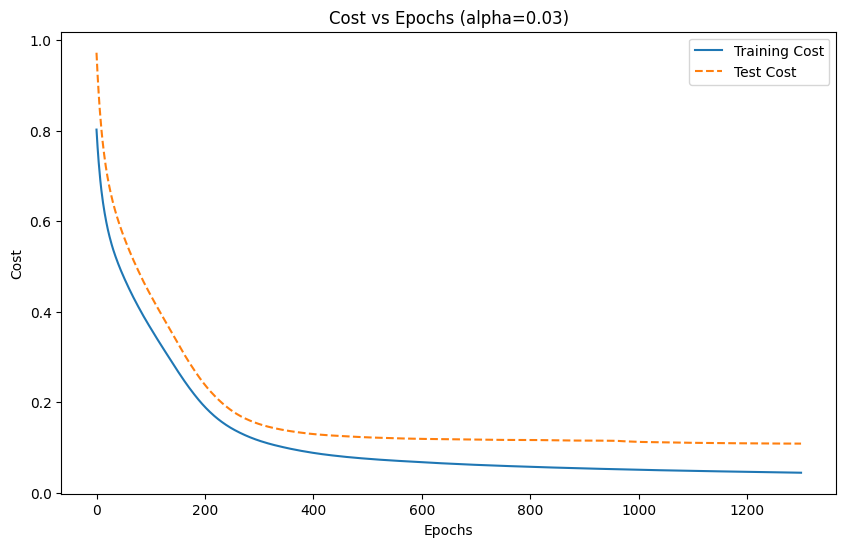

In [33]:
### TASK 5 CODE STARTS HERE ###
import matplotlib.pyplot as plt

# Metrics Helper Function
def calculate_metrics(A, Y):
    predictions = (A > 0.5).astype(int)
    TP = np.sum((predictions == 1) & (Y == 1))
    TN = np.sum((predictions == 0) & (Y == 0))
    FP = np.sum((predictions == 1) & (Y == 0))
    FN = np.sum((predictions == 0) & (Y == 1))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    dice = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    
    return accuracy, precision, recall, f1, dice, TP, TN, FP, FN

# 1. Hyperparameters
alpha = 0.03  # Increased learning rate slightly
epochs = 1300

train_costs = []
test_costs = []

print(f"Starting training for {epochs} epochs with alpha = {alpha}...")
min_test_cost = float('inf')  # Initialize with infinity

# 2. Training Loop
for i in range(epochs):
    # Forward Prop (Train)
    Z1, A1, Z2, A2, Z3, A3 = forward_prop(Xtrain, W1, b1, W2, b2, W3, b3)
    cost_train = compute_cost(A3, Ytrain, mtrain)
    train_costs.append(cost_train)
    # Save weights if this is the best score so far
    if cost_test < min_test_cost:
        min_test_cost = cost_test
        np.savez('best_weights.npz', W1=W1, b1=b1, W2=W2, b2=b2, W3=W3, b3=b3)
        print(f"New best weights saved at epoch {i} with test cost: {min_test_cost:.4f}")
    
    # Back Prop
    dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, A3, W2, W3, Xtrain, Ytrain)
    
    # Update Weights
    W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, 
                                           dW1, db1, dW2, db2, dW3, db3, alpha)
    
    # Forward Prop (Test)
    Z1t, A1t, Z2t, A2t, Z3t, A3t = forward_prop(Xtest, W1, b1, W2, b2, W3, b3)
    cost_test = compute_cost(A3t, Ytest, mtest)
    test_costs.append(cost_test)
    
    if i % 100 == 0:
        print(f"Epoch {i}: Train Cost = {cost_train:.4f} | Test Cost = {cost_test:.4f}")

# 3. Final Report
_, _, _, _, _, A3_train = forward_prop(Xtrain, W1, b1, W2, b2, W3, b3)
_, _, _, _, _, A3_test = forward_prop(Xtest, W1, b1, W2, b2, W3, b3)

acc_te, prec_te, rec_te, f1_te, dice_te, tp_te, tn_te, fp_te, fn_te = calculate_metrics(A3_test, Ytest)

print("\n" + "="*40)
print("FINAL PERFORMANCE REPORT")
print("="*40)
print(f"Accuracy:   {acc_te:.4f}")
print(f"Precision:  {prec_te:.4f}")
print(f"Recall:     {rec_te:.4f}")
print(f"F1 Score:   {f1_te:.4f}")
print("-" * 40)
print("Confusion Matrix:")
print(f"TP: {tp_te}, TN: {tn_te}, FP: {fp_te}, FN: {fn_te}")

# 4. Plot
plt.figure(figsize=(10, 6))
plt.plot(train_costs, label='Training Cost')
plt.plot(test_costs, label='Test Cost', linestyle='--')
plt.title(f'Cost vs Epochs (alpha={alpha})')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()

### TASK 5 CODE ENDS HERE ###